
# The Skip-gram model







## Word embeddings

The main goal of this problem is to create **word embeddings**, i.e., a mapping from words to a vector space. These vectors can indicate semantic similarities between words.
The two most popular algorithms for constructing word embeddings are **skip-gram** and **CBOW** (Continous Bag Of Words).
In both algorithms, word embeddings are learned through an auxiliary task. In CBOW, this task is predicting the current word from a window of **context** words, i.e., surrounding words. The auxiliary task under the skip-gram scheme is the opposite: given a current word, the task is predicting context words. After training, we use learned weights from the model as our word embeddings.



## Skip gram general architecture

*The global architecture of the base model of the skip-gram. Picture taken from [this website](https://www.geeksforgeeks.org/implement-your-own-word2vecskip-gram-model-in-python/)* 


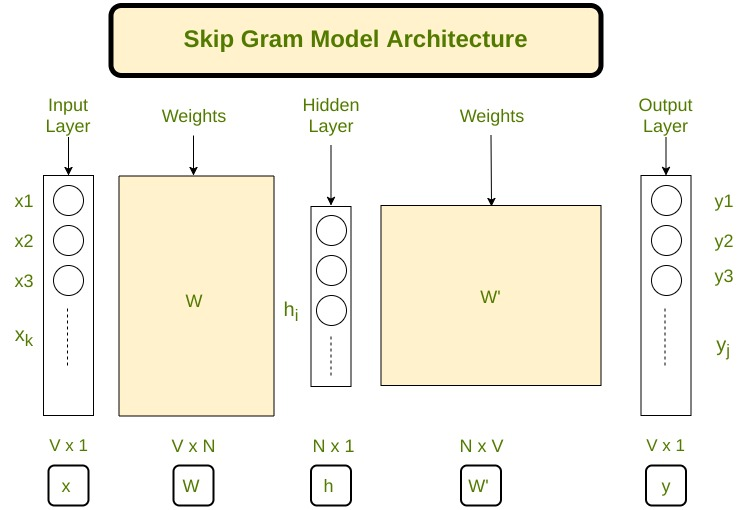


We consider a vocabulary of words $V$ for which we wish to create embeddings of dimension $N$, i.e., $\mathbf e_{wrd}(w) \in \mathbb{R}^N$. Additionally, we assume our skip-gram model considers the $T$ words preceding and following our input word in the prediction step.

The first step in the algorithm for training a skip-gram model is the processing of each sample in our training data into a (multi-) set of pairs of input and context words ($w_i$, $w_t$), where $t\in \{-T, -(T-1), \dots, T\}$ indicates the position of $w_t$ with respect to $w_i$ in the training sample. 

We project the *one-hot* encoding of our input word $\mathbf e_{oh}(w_i)\in \mathbb{R}^{|V|}$ with a weight matrix $W \in \mathbb{R}^{|V| \times N}$. This projection is then multiplied by weight matrix $W'$ and the softmax function is applied, resulting in a vector that represents the predicted probability of $w\in V$ appearing in the size $2T$ context window around word $w_i$. Our goal is to maximize the log-likelihood of our data: $\log p(w_t|w_i, W, W')$, which is typically done using gradient-descent methods.

At the end of training, we use the rows of matrix $W$ as our word embeddings, i.e., $\mathbf e_{wrd}(w_i) = W_i$.

Note: the columns of $W'$ will give us "context embeddings" $\mathbf e_{ctx}$, but we are only interested in the word embeddings.



## Negative sampling

During training, our goal is to maximize $$p(w_t\mid w_i)=\frac{1}{Z(w_i)}\exp(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)) = \frac{1}{Z(w_i)}\exp(W_i \cdot (W')^\top_t)  $$

However $Z(w)=\sum_{w' \in V} \exp(\mathbf e_{wrd}(w) \cdot \mathbf e_{ctx}(w'))$ can take a long time to compute for large $V$.
We can instead use **negative sampling**: rather than computing the $|V|$-dimensional probability distribution via the softmax, we use the sigmoid function between the ground truth label and the label of a word drawn uniformly at random from $V$. 

Formally, for each pair of words in our training data $(w_i,w_t)$, we randomly sample (with replacement) a set $C^-$ from $V$. Our objective under the negative sampling approach becomes

 $$\underset{W,W'}{\text{arg max}} \sum_{(w_i,w_t,C^-)} \left(  \log(p(w_t\mid w_i)) +  \sum_{w^- \in C^-}  \log(1-p(w^-|w_i)) \right)$$

where we compute $p(w_t\mid w_i)$ using the sigmoid function: $p(w_t|w_i) = \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))$.


# Hyperparameters

In [ ]:
V_size = 12000 #size of the vocabulary
N = 300 #embedding size
window_size = 5
K= 20 #number of negative samples per positive pairs (wt,wi)
Step_size = 500000

# Data loading and preprocessing

In [ ]:
import nltk
import numpy as np
nltk.download('brown')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import brown
from nltk.corpus import stopwords
from numpy import save
from matplotlib import pyplot as plt

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
sentences = brown.sents()
print(len(sentences))
print(sentences[:3])

57340
[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ['The', 'September-October', 'term', 'jury', 'had', 'been', 'charged', 'by', 'Fulton', 'Superior', 'Court', 'Judge', 'Durwood', 'Pye', 'to', 'investigate', 'reports', 'of', 'possible', '``', 'irregularities', "''", 'in', 'the', 'hard-fought', 'primary', 'which', 'was', 'won', 'by', 'Mayor-nominate', 'Ivan', 'Allen', 'Jr.', '.']]


In [ ]:
import string
stop_words = set(stopwords.words('english')) 
def preprocessing(sentences): 
    training_data = [] 
    for i in range(len(sentences)): 
        #sentences[i] = sentences[i].strip() 
        sentence = sentences[i] 
        x = [word.strip(string.punctuation) for word in sentence] 
        x = [word.lower() for word in x] 
        x = [word for word in x if word!='' and word.isalpha()]
        x = [word for word in x if word not in stop_words]
        if x:
          training_data.append(x) 
    return training_data 
sentences = preprocessing(sentences)
print(sentences[:3])

[['fulton', 'county', 'grand', 'jury', 'said', 'friday', 'investigation', 'recent', 'primary', 'election', 'produced', 'evidence', 'irregularities', 'took', 'place'], ['jury', 'said', 'presentments', 'city', 'executive', 'committee', 'charge', 'election', 'deserves', 'praise', 'thanks', 'city', 'atlanta', 'manner', 'election', 'conducted'], ['term', 'jury', 'charged', 'fulton', 'superior', 'court', 'judge', 'durwood', 'pye', 'investigate', 'reports', 'possible', 'irregularities', 'primary', 'ivan', 'allen', 'jr']]


# Prepare data for training


## Extract V

In [ ]:
from collections import defaultdict
count = defaultdict(int)
for sentence in sentences: 
    for word in sentence: 
      count[word] += 1

In [ ]:
import operator
sorted_counts = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_counts)

[('one', 3297), ('would', 2714), ('said', 1961), ('new', 1635), ('could', 1601), ('time', 1598), ('two', 1412), ('may', 1402), ('first', 1361), ('like', 1292), ('man', 1207), ('even', 1170), ('made', 1125), ('also', 1069), ('many', 1030), ('must', 1013), ('af', 996), ('back', 966), ('years', 958), ('much', 937), ('way', 909), ('well', 897), ('people', 847), ('mr', 844), ('little', 831), ('state', 807), ('good', 806), ('make', 794), ('world', 787), ('still', 782), ('see', 772), ('men', 763), ('work', 762), ('long', 753), ('get', 749), ('life', 715), ('never', 697), ('day', 687), ('another', 684), ('know', 683), ('last', 676), ('us', 675), ('might', 672), ('great', 665), ('old', 661), ('year', 658), ('come', 630), ('since', 628), ('go', 626), ('came', 622), ('right', 613), ('states', 612), ('used', 611), ('take', 610), ('three', 610), ('house', 591), ('use', 591), ('without', 583), ('place', 570), ('american', 569), ('around', 562), ('however', 552), ('home', 547), ('small', 542), ('foun

Select the V most commons

In [ ]:
vocabulary = sorted_counts[:V_size]

## Convert the corpus into indices

Many of our operations can be vectorized if we represent our words with unique ids rather than the original string. 

We assign an id to all words and create lookup tables for word to index and index to word for fast lookup. For the rest of the problem, you will work with these indices.

In [ ]:
# Assign ids and create lookup tables
word_to_index = {'UNK': 0}
index_to_word = ['UNK']
for idx, tup in enumerate(vocabulary,1):
  word_to_index[tup[0]] = idx
  index_to_word.append(tup[0])

In [ ]:
assert len(index_to_word) == len(word_to_index)
print(len(index_to_word))

12001


Now we can transform our dataset by replacing the words with their index.

In [ ]:
sentences_index = []
for sent in sentences:
  ids=[]
  for word in sent:
    if word in word_to_index:
      ids.append(word_to_index[word])
    else: 
      ids.append(0)
  sentences_index.append(ids)
print(sentences_index[:3])

[[5128, 513, 2100, 1459, 3, 1655, 1982, 419, 959, 1231, 1027, 343, 8702, 95, 59], [1459, 3, 0, 118, 1836, 467, 713, 1231, 5373, 5129, 2730, 118, 2881, 702, 1231, 1837], [1202, 1459, 1769, 5128, 2197, 287, 1232, 0, 0, 7058, 1117, 136, 8702, 959, 0, 4520, 1262]]


Here you go ! We have preprocessed the corpus. Now it's your turn to implement the rest of the notebook, in order to extract samples, train the model and analyze the embeddings you obtain.

## Extract pair (word, context)

**Task 1.a.** : Create a list of training samples $C$: for each word $w_i$ in the corpus, add a tupple ($w_i$, $w_t$) for each context word $w_t$ in $w_i$'s context window.

Remember we defined the parameters window_size in the beginning of this notebook.

In [ ]:
#Solution task 1.a.
dataset_tmp = []
for sentence in sentences_index:
    for i in range(len(sentence)):
        index = 1
        while index <= window_size and i-index>=0:  #sliding window to the left of the word
            dataset_tmp.append(tuple((sentence[i],sentence[i-index])))
            index +=1
        index = 1
        while index <= window_size and i + index < len(sentence): #sliding window to the right of the word
            dataset_tmp.append(tuple((sentence[i], sentence[i +index])))
            index += 1
print(len(dataset_tmp))
print(dataset_tmp[:15])

3571954
[(5128, 513), (5128, 2100), (5128, 1459), (5128, 3), (5128, 1655), (513, 5128), (513, 2100), (513, 1459), (513, 3), (513, 1655), (513, 1982), (2100, 513), (2100, 5128), (2100, 1459), (2100, 3)]


## Negative sampling



**Task 1.b.**: Create negative samples: for each positive sample ($w_i$, $w_t$) in $C$, we want to create a set $C^-$ of $K$ negative samples. We sample a word proportional to its number of occurences in the corpus and the negative samples should be different from the positive context word $w_t$. Store all the training data as a list of tuple ($w_i$, $w_t$, $C^-$)

In [ ]:
#Solution task 1.b.
dataset = []
count = 0
probs = list(np.array(list(zip(*vocabulary))[1])/sum(list(zip(*vocabulary))[1]))  #calculate probabilities of words to be drawn
words_to_sample = list(list(zip(*vocabulary))[0])  #create the list of the words to draw

for i in range(len(words_to_sample)):
    words_to_sample[i] = word_to_index[words_to_sample[i]]   #convert words into indeces
words_to_sample = tuple(words_to_sample)

negative_samples = np.random.choice(size = K*len(dataset_tmp),a= words_to_sample, p=probs)  #sample the words only one time to optimize the code
print(len(words_to_sample))
for i in range(len(dataset_tmp)):
    if(count % Step_size == 0):
        print(f"sample {count}/{len(dataset_tmp)}")
    sample_list = []
    sample_list.append(dataset_tmp[i][0])
    sample_list.append(dataset_tmp[i][1])
    index = K*i
    if dataset_tmp[i][1] in negative_samples[index:index+20]: #check if the positive word is present in the list of negative words
        for j in range(K):
            if(negative_samples[index+j] == dataset_tmp[i][1]):
                negative_sample = negative_samples[index+j]
                while(negative_sample == dataset_tmp[i][1]):  #sample another word to replace the positive word
                    negative_sample = np.random.choice(a=words_to_sample, p=probs)
                negative_samples[index+j] = negative_sample


    to_add_list = list(negative_samples[index:index+20])
    for element in to_add_list:  #create the sample with positive word, and negative words
      sample_list.append(element)     
    count +=1
    dataset.append(sample_list)

print(dataset[:3])
print(count)

12000
sample 0/3571954
sample 500000/3571954
sample 1000000/3571954
sample 1500000/3571954
sample 2000000/3571954
sample 2500000/3571954
sample 3000000/3571954
sample 3500000/3571954
[[5128, 513, 8331, 759, 9192, 1297, 937, 2592, 153, 2141, 85, 7791, 1024, 444, 14, 9343, 303, 690, 274, 2, 8918, 6], [5128, 2100, 668, 1838, 1070, 3030, 2624, 4769, 44, 747, 123, 1580, 207, 132, 357, 2235, 3454, 787, 7700, 2324, 2535, 1298], [5128, 1459, 25, 8960, 378, 2160, 190, 860, 647, 2404, 2140, 179, 95, 2528, 909, 1853, 2282, 5641, 27, 1045, 23, 200]]
3571954


# Learning

## Calculate gradient

Recall our training objective under the negative sampling approach. Under this objective, we can define our loss function with respect to our training data $\mathcal{D}$ as:

$$L(W,W') = - \sum_{(w_i,w_t,C^-) \in \mathcal{D}}\left (\log(\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))) +  \sum_{w^- \in C^-}  \log(1-\sigma(\mathbf e_{wrd}(w_i) \cdot e_{ctx}(w^-)))\right )$$

For the rest of the assignment you can consider the case of **Stochastic Gradient Descent**. This means at each iteration we consider only one datapoint $(w_i,w_t,C^-)$, we compute the loss and the gradients with this datapoint and update the parameters $e_{wrd}(w_i),e_{ctx}(w_t)$ and all the $e_{ctx}(w^-)$ for $w^- \in C^-$

**Task 2.a.** : Write down the partial derivative of the loss with respect to the word embedding $\mathbf e_{wrd}(w_i)$ and context embedding $\mathbf e_{ctx}(w_t)$. Additionally, provide the partial derivative of the loss with respect to a single negative sample $w^- \in C^-$: $\nabla_{\mathbf e_{wrd}(w_i)} L$, $\nabla_{\mathbf e_{ctx}(w_t)} L$, $\nabla_{\mathbf e_{ctx}(w^-)} L$


**Solution task 2.a.** :

$\nabla_{\mathbf e_{wrd}(w_i)} L =-\frac{\partial \log(\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)))}{\partial \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))}\frac{\partial \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))}{\partial \mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)}\frac{\partial \mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)}{\partial \mathbf e_{wrd}(w_i)} - \sum_{w^- \in C^-}\frac{\partial \log(1-\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-)))}{\partial (1-\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-)))}\frac{\partial (1-\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-)))}{\partial \mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-)}\frac{\partial \mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-)}{\partial \mathbf e_{wrd}(w_i)} \\=- \left (\frac{\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))}{\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))}  (1- \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)))\mathbf e_{ctx}(w_t) -  \sum_{w^- \in C^-} \frac{1- \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-))}{1-\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-))}(\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-)))\mathbf e_{ctx}(w^-)\right ) \\=- \left ((1- \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)))\mathbf e_{ctx}(w_t) -  \sum_{w^- \in C^-} \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-))\mathbf e_{ctx}(w^-)\right )\\=- (1- \sigma(t))\mathbf e_{ctx}(w_t) +  \sum_{w^- \in C^-} \sigma(r) \mathbf e_{ctx}(w^-)$

\
Where we defined:

 $t=\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)$
 
 $r=\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-)$

\
$\nabla_{\mathbf e_{ctx}(w_t)} L = -\frac{\partial \log(\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)))}{\partial \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))}\frac{\partial \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))}{\partial \mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)}\frac{\partial \mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)}{\partial \mathbf e_{ctx}(w_t)}\\=- \frac{\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))}{\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))}(1- \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)))e_{wrd}(w_i)\\= - (1- \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)))e_{wrd}(w_i)\\ =- (1- \sigma(t))e_{wrd}(w_i) $

\

$\nabla_{\mathbf e_{ctx}(w^-)} L = -\frac{\partial \log(1-\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-)))}{\partial (1-\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-)))}\frac{\partial (1-\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-)))}{\partial \mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-)}\frac{\partial \mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-)}{\partial \mathbf e_{ctx}(w^-)}\\= \frac{1- \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-))}{1-\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-))}(\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-)))\mathbf e_{ctx}(w^-)\\=  \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-))e_{wrd}(w_i)
\\=\sigma(r)e_{wrd}(w_i)$

\

For the last derivative we assumed that all the words $w^- \in C^-$ are different from each other.


**Task 2.b** : Write down the formula of the gradient update of $\mathbf e_{wrd}(w_i)$, $\mathbf e_{ctx}(w_t)$ and $\mathbf e_{ctx}(w^-)$.

**Solution task 2.b. :**

$e_{wrd}^{(t+1)}(w_i) = e_{wrd}^{(t)}(w_i) - \eta\nabla_{\mathbf e_{wrd}^{(t)}(w_i)} L$

$e_{ctx}^{(t+1)}(w_t) = e_{ctx}^{(t)}(w_t) - \eta\nabla_{\mathbf e_{ctx}^{(t)}(w_t)} L$

$e_{ctx}^{(t+1)}(w^-) = e_{ctx}^{(t)}(w^-) - \eta\nabla_{\mathbf e_{ctx}^{(t)}(w^-)} L$

Where $\eta$ denotes the learning rate.


## Training

**Task 3 :** With the dataset of positive and negative samples you created, implement the gradient descent algorithm. You have to initialize the matrices W and W' with random weights between -0.8 and 0.8, compute the gradients efficiently and launch the training on several epochs. Draw the curve of the loss in function of the total number of steps.

In [ ]:
#training params
lr = 0.03
epochs = 10

epoch: 1/10
sample: 0/3571954
sample: 500000/3571954
sample: 1000000/3571954
sample: 1500000/3571954
sample: 2000000/3571954
sample: 2500000/3571954
sample: 3000000/3571954
sample: 3500000/3571954
epoch: 2/10
sample: 0/3571954
sample: 500000/3571954
sample: 1000000/3571954
sample: 1500000/3571954
sample: 2000000/3571954
sample: 2500000/3571954
sample: 3000000/3571954
sample: 3500000/3571954
epoch: 3/10
sample: 0/3571954
sample: 500000/3571954
sample: 1000000/3571954
sample: 1500000/3571954
sample: 2000000/3571954
sample: 2500000/3571954
sample: 3000000/3571954
sample: 3500000/3571954
epoch: 4/10
sample: 0/3571954
sample: 500000/3571954
sample: 1000000/3571954
sample: 1500000/3571954
sample: 2000000/3571954
sample: 2500000/3571954
sample: 3000000/3571954
sample: 3500000/3571954
epoch: 5/10
sample: 0/3571954
sample: 500000/3571954
sample: 1000000/3571954
sample: 1500000/3571954
sample: 2000000/3571954
sample: 2500000/3571954
sample: 3000000/3571954
sample: 3500000/3571954
epoch: 6/10
sam

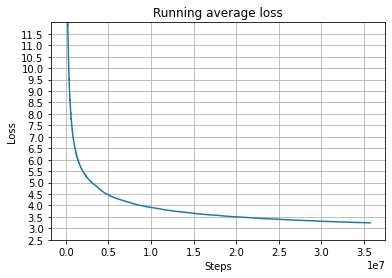

train end


In [ ]:
#Solution task 3
W = np.random.uniform(-0.8, 0.8,size=(V_size+1,N))
W_prime = np.random.uniform(-0.8, 0.8,size=(V_size+1,N))

import math


def sigmoid(x):
  return 1 / (1 + math.e ** -x)


def wrd_gradient(W,W_prime,sample):  # calculate the word gradient
    first_term = -(1-sigmoid(np.dot(W[sample[0]],W_prime[sample[1]])))*W_prime[sample[1]]
    second_term = 0
    for i in range(K):
        second_term += (sigmoid(np.dot(W[sample[0]],W_prime[sample[2+i]])))*W_prime[sample[2+i]]

    return first_term + second_term


def ctx_gradient(W,W_prime,sample,negative = False,index = 0):  # calculate the context gradient for both negative and postive words
    if negative:
        gradient = (sigmoid(np.dot(W[sample[0]], W_prime[sample[2+index]]))) * W[sample[0]]
    else:
        gradient = -(1-sigmoid(np.dot(W[sample[0]],W_prime[sample[1]])))*W[sample[0]]

    return gradient


def loss_one_sample(W,W_prime,sample):  # calculate the loss for a single sample
    first_term = -np.log(sigmoid(np.dot(W[sample[0]], W_prime[sample[1]])))
    second_term = 0
    for i in range(K):
        second_term += - np.log(1 - sigmoid(np.dot(W[sample[0]], W_prime[sample[2 + i]])))

    return first_term + second_term

##fit
total_loss = 0
counter = 0

steps_loss = []

for epoch in range(epochs):
    print(f"epoch: {epoch + 1}/{epochs}")

    np.random.shuffle(dataset)  # shuffle the datatset at each iteration
    dataset = list(dataset)
    counter = 0
    for sample in dataset:
        if (counter % Step_size == 0):
            total_loss = 0
            print(f"sample: {counter}/{len(dataset)}")

        steps_loss.append(loss_one_sample(W, W_prime, sample))  # calculate the sample loss
        gradient_wrd = wrd_gradient(W,W_prime,sample)

        gradient_ctx = ctx_gradient(W, W_prime, sample)
        gradient_ctx_neg = []

        # Steps of stochastic gradient descent
        for i in range(K):
            gradient_ctx_neg.append(ctx_gradient(W, W_prime, sample,negative=True,index = i))
        W[sample[0]] = W[sample[0]] - lr*gradient_wrd
        W_prime[sample[1]] = W_prime[sample[1]] - lr * gradient_ctx
        for i in range(K):
            W_prime[sample[2+i]] = W_prime[sample[2+i]] - lr * gradient_ctx_neg[i]
        counter +=1



import pandas as pd
from itertools import accumulate

# Calculate the average of the accumulated loss
average_windows_size = 100000
average_loss = list(accumulate(steps_loss)) / np.arange(1,len(steps_loss) + 1)

# Plot The average of accumulated loss over steps
plt.plot(average_loss)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yticks(np.arange(0,12,0.5))
plt.ylim(top=12,bottom=2.5)
plt.grid(True)
plt.title('Running average loss')
plt.savefig("loss_skip_gram.png")
plt.show()

print("train end")

# Save both the matrices
save("W.npy",W)
save("W_prime.npy",W_prime)

Now you can use the matrix W for words embeddings.

We recommend you to save your embedding matrix for the rest of the problem. You have to hand it in with your assignment so that we can reproduce your results.

# Analyzing the embeddings

## Cosine similarity calculation

One way to compare vectors is the cosine similarity, which is defined as :
$$sim(\mathbf x,\mathbf y) = \frac{\mathbf x \cdot \mathbf y}{||\mathbf x|| ||\mathbf y||}$$

**Task 4.a.** : Fill the tables with the cosine similarity between the given words and comment the results :


| x      | y       | sim(x,y)     | 
|--------|---------|--------------|
|film    |movie    |    0.198          |
|film    |water    |       0.156       |
|home    |house    |          0.277    |
|home    |yellow   |        0.139      |
|father  |mother   |      0.327        |
|father  |street   |      0.077        |
|street  |avenue   |        0.259      |
|writer  |poet     |        0.308      |
|writer  |potatoes |       0.042       |
|boy     |girl     |       0.377       |
|children|young    |       0.247       |
|children|old      |        0.193      |
|eat     |food     |     0.257         |
|eat     |sport    |     0.022         |
|water   |liquid   |      0.221        |
|water   |solid    |      0.181        |








In [ ]:
from numpy.linalg import norm

W = np.load("W.npy")

def cosine_similarity(emd_x,emd_y):  # function to calculate similarity between two words
  return np.round(np.dot(emd_x,emd_y)/(norm(emd_x)*norm(emd_y)),decimals=4)

In [ ]:
#Solution task 4.a.
x = ["film","film","home","home","father","father","street","writer","writer","boy","children","children","eat","eat","water","water"]
y = ["movie","water","house","yellow","mother","street","avenue","poet","potatoes","girl","young","old","food","sport","liquid","solid"]

for i in range(len(x)):
    sim = cosine_similarity(W[word_to_index[x[i]]],W[word_to_index[y[i]]])
    print(f"Similarity between {x[i]} and {y[i]} is : {sim}")


Similarity between film and movie is : 0.1979
Similarity between film and water is : 0.1555
Similarity between home and house is : 0.2768
Similarity between home and yellow is : 0.1386
Similarity between father and mother is : 0.3274
Similarity between father and street is : 0.0766
Similarity between street and avenue is : 0.2588
Similarity between writer and poet is : 0.3075
Similarity between writer and potatoes is : 0.0423
Similarity between boy and girl is : 0.3769
Similarity between children and young is : 0.2465
Similarity between children and old is : 0.1931
Similarity between eat and food is : 0.2565
Similarity between eat and sport is : 0.0222
Similarity between water and liquid is : 0.2213
Similarity between water and solid is : 0.1806


### Analysis

By looking the results we can observe that the skip gram model has learned a good embedding for the given words, since we have an higher score for word pairs that have a common meaning and that are typically associated together, like for example "boy-girl" or "father-mother" while we have a lower score for word pairs that are not similar like "writer-potatoes".
However also for the pairs that have similar words the cosine similarity is not so high (max score is 0.377), so maybe we can improve the results by improving negative sampling approach (when we take a negative sample for a given word x we should check that this word never appear as positive sample for x, by checking all the samples that we have) or by using a more complex model. 


**Task 4.b.** Show the 10 nearest words of the following words with the associated cosine similarity values : [*love, car, president, monday, green, money, health, faith, book, france, swiss, spring*] along with 5 words of your choice. Provide a brief description of your observations.



In [ ]:
#Solution task 4.b.
x = ["love", "car", "president", "monday", "green", "money",
     "health", "faith", "book","france", "swiss", "spring",
     ##my words
     "castle", "picture", "sand", "tree", "sea",
     ]

for word in x:
    cosine = []
    for i in range(W.shape[0]):
      cosine.append(cosine_similarity(W[i],W[word_to_index[word]]))
    index = np.argsort(cosine) #take the indices sorted based on the values contained in cosine

    to_print = []
    for i in range(1,11):
      to_print.append((index_to_word[index[W.shape[0] -1 - i]], cosine[index[W.shape[0] -1 -i]]))
    print(word + " -> " + str(to_print))


love -> [('life', 0.312), ('ominous', 0.2962), ('kingdom', 0.2922), ('preached', 0.2919), ('say', 0.2908), ('noble', 0.2907), ('incest', 0.2846), ('cling', 0.2829), ('told', 0.2828), ('fallen', 0.2818)]
car -> [('barn', 0.3544), ('cars', 0.3432), ('police', 0.3364), ('away', 0.335), ('coat', 0.3282), ('block', 0.3273), ('parked', 0.3228), ('slid', 0.321), ('road', 0.3202), ('ne', 0.3183)]
president -> [('kennedy', 0.437), ('candidate', 0.3847), ('chairman', 0.3595), ('eisenhower', 0.3514), ('secretary', 0.344), ('adviser', 0.3296), ('rusk', 0.328), ('nixon', 0.32), ('party', 0.3121), ('mr', 0.308)]
monday -> [('sunday', 0.3613), ('night', 0.361), ('tuesday', 0.3607), ('saturday', 0.3478), ('thursday', 0.3325), ('victory', 0.3254), ('afternoon', 0.3162), ('ballroom', 0.3151), ('poll', 0.3134), ('wednesday', 0.3117)]
green -> [('detectable', 0.3108), ('blue', 0.3103), ('river', 0.3075), ('wore', 0.3061), ('herd', 0.2974), ('hips', 0.2968), ('light', 0.2957), ('flashing', 0.2944), ('white

### Analysis

Looking at the nearest words we can notice that in general the first two words are very similar or are linked in some way to the words we are analysing, for example we have the word pairs "president-Kennedy" or "France-Germany", "car-cars", some exceptions are the word pairs "castle-inscribed", "green-detectable". Therefore we can conclude that in general the skip gram found a good embedding for our vocabulary, and that words similar to each other have similar embeddings. However if we go beyond the two nearest words not always we find neighbours that make sense, for instance we have "sea-thousands" or "castle-skirt".

One of the reasons for these strange neighbors could be that some words are less frequent than others in our training set, for example the pair "president-Kennedy" has a really high score compared to the others, and this can be due to the fact that this two words appear very frequently in our dataset, while the word "castle" does not seem to have a good embedding since its neighbours are not so similar and the cosine similarities are lower compared to other words, and this can be due to scarce presence of the word "castle" in our dataset.

To conclude we believe that the skip gram work well, but we can certainly find some ways to improve it, like discussed in the previous point.

## Words analogies

**Task 5** : As explained in class, we can also evaluate word embeddings with word analogies.
Compare the cosine similarities between following vectors and comment on the results. Find 2 other such examples.

| x                            | y       | sim(x,y)     | 
|------------------------------|---------|--------------|
|london - england + germany    | berlin  |    0.225          |
|father - man + woman          |mother   |     0.326         |
|children - young + old        |parents  |      0.108        |
|sister - girl + boy           |brother  |       0.311       |
|happiness - good + bad        |pain     |         0.154     |
|light - day + night       |darkness     |         0.250     |
|food - eat + drink        |water     |         0.142     |
|friend - love + hate        |enemy    |         0.202     |


In [ ]:
#Solution task 5
x_1 = ["london", "father", "children", "sister", "happiness", "light", "food", "friend"]
x_2 = ["england", "man", "young", "boy", "good", "day", "eat", "love"]
x_3 = ["germany", "woman", "old", "boy", "bad", "night", "drink", "hate"]

y = ["berlin", "mother", "parents", "brother", "pain", "darkness", "water", "enemy"]

for i in range(len(y)):
  sim = cosine_similarity(W[word_to_index[x_1[i]]] - W[word_to_index[x_2[i]]] + W[word_to_index[x_3[i]]],
                          W[word_to_index[y[i]]])
  print(f"Similarity between [{x_1[i]} - {x_2[i]} + {x_3[i]}]and {y[i]} is : {sim}")



Similarity between [london - england + germany]and berlin is : 0.225
Similarity between [father - man + woman]and mother is : 0.3263
Similarity between [children - young + old]and parents is : 0.1079
Similarity between [sister - boy + boy]and brother is : 0.3112
Similarity between [happiness - good + bad]and pain is : 0.1535
Similarity between [light - day + night]and darkness is : 0.2503
Similarity between [food - eat + drink]and water is : 0.1424
Similarity between [friend - love + hate]and enemy is : 0.2015


### Analysis

In general we have also in this case high similarities (between 0.2 and 0.3) for the words that are linked to each other, however there are two exceptions:

The first exception is the third pair where the problem may be that we should use "adults" instead of "parents" to get an higher score (in fact we obtain 0.17 using "adults" instead of "parents").

The second exception is the example "[food - eat + drink] / water" , where the problem may be that "food" is a general word while "water" refers to a specific drink, so this may produce a lower score.

To conclude, even with this analysis we can again state that the skip gram has found good embeddings in general.


#Visualization

**t-distributed stochastic neighbor embedding ([t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf))** is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map.




The following code transforms the embeddings of W from dimension N to dimension 2.

In [ ]:
from sklearn.manifold import TSNE

labels = []
tokens = []

for i in range(len(index_to_word)):
    tokens.append(W[i,:])
    labels.append(index_to_word[i])

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)


**Task 6** : Plot 3 graphs with the 2D coordinates of the first 100, 500 and 1000 words with their labels. Analyze the results, in particular identify some thematic clusters that your visualizations reveal.

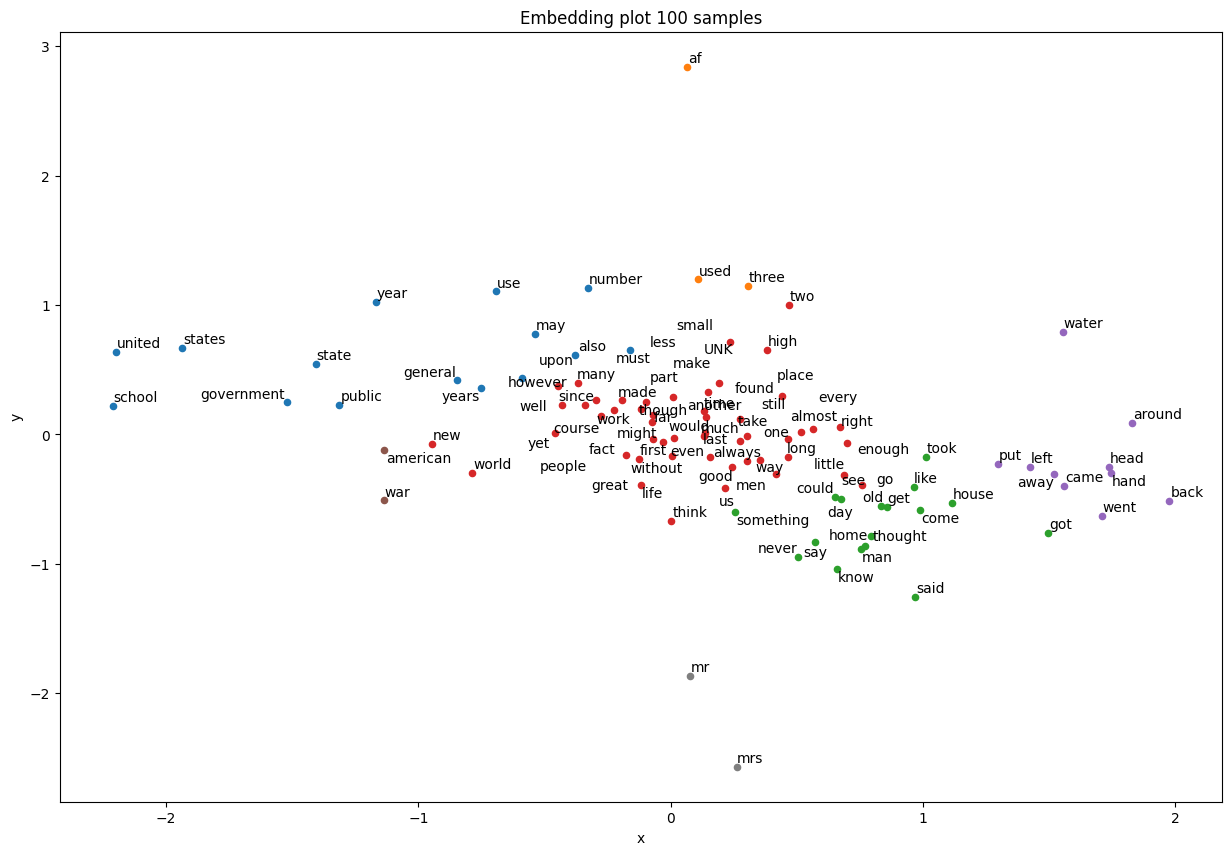

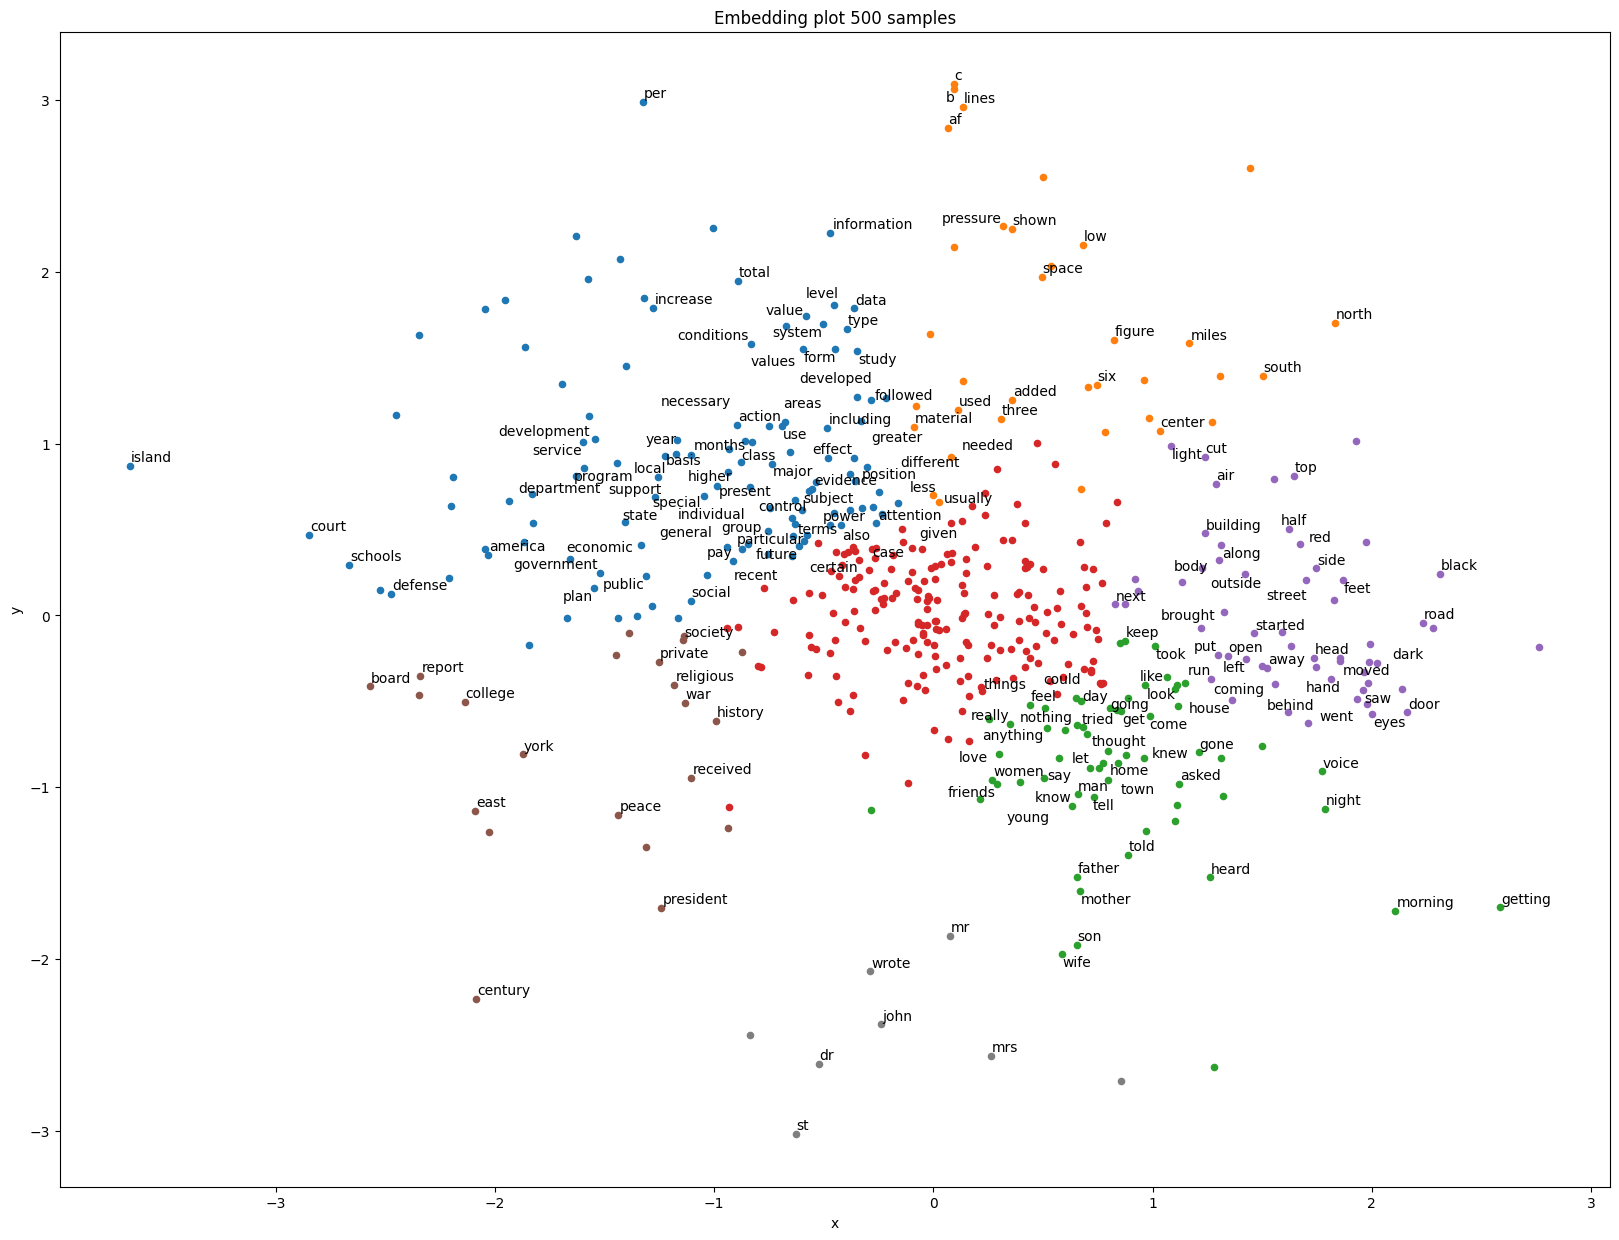

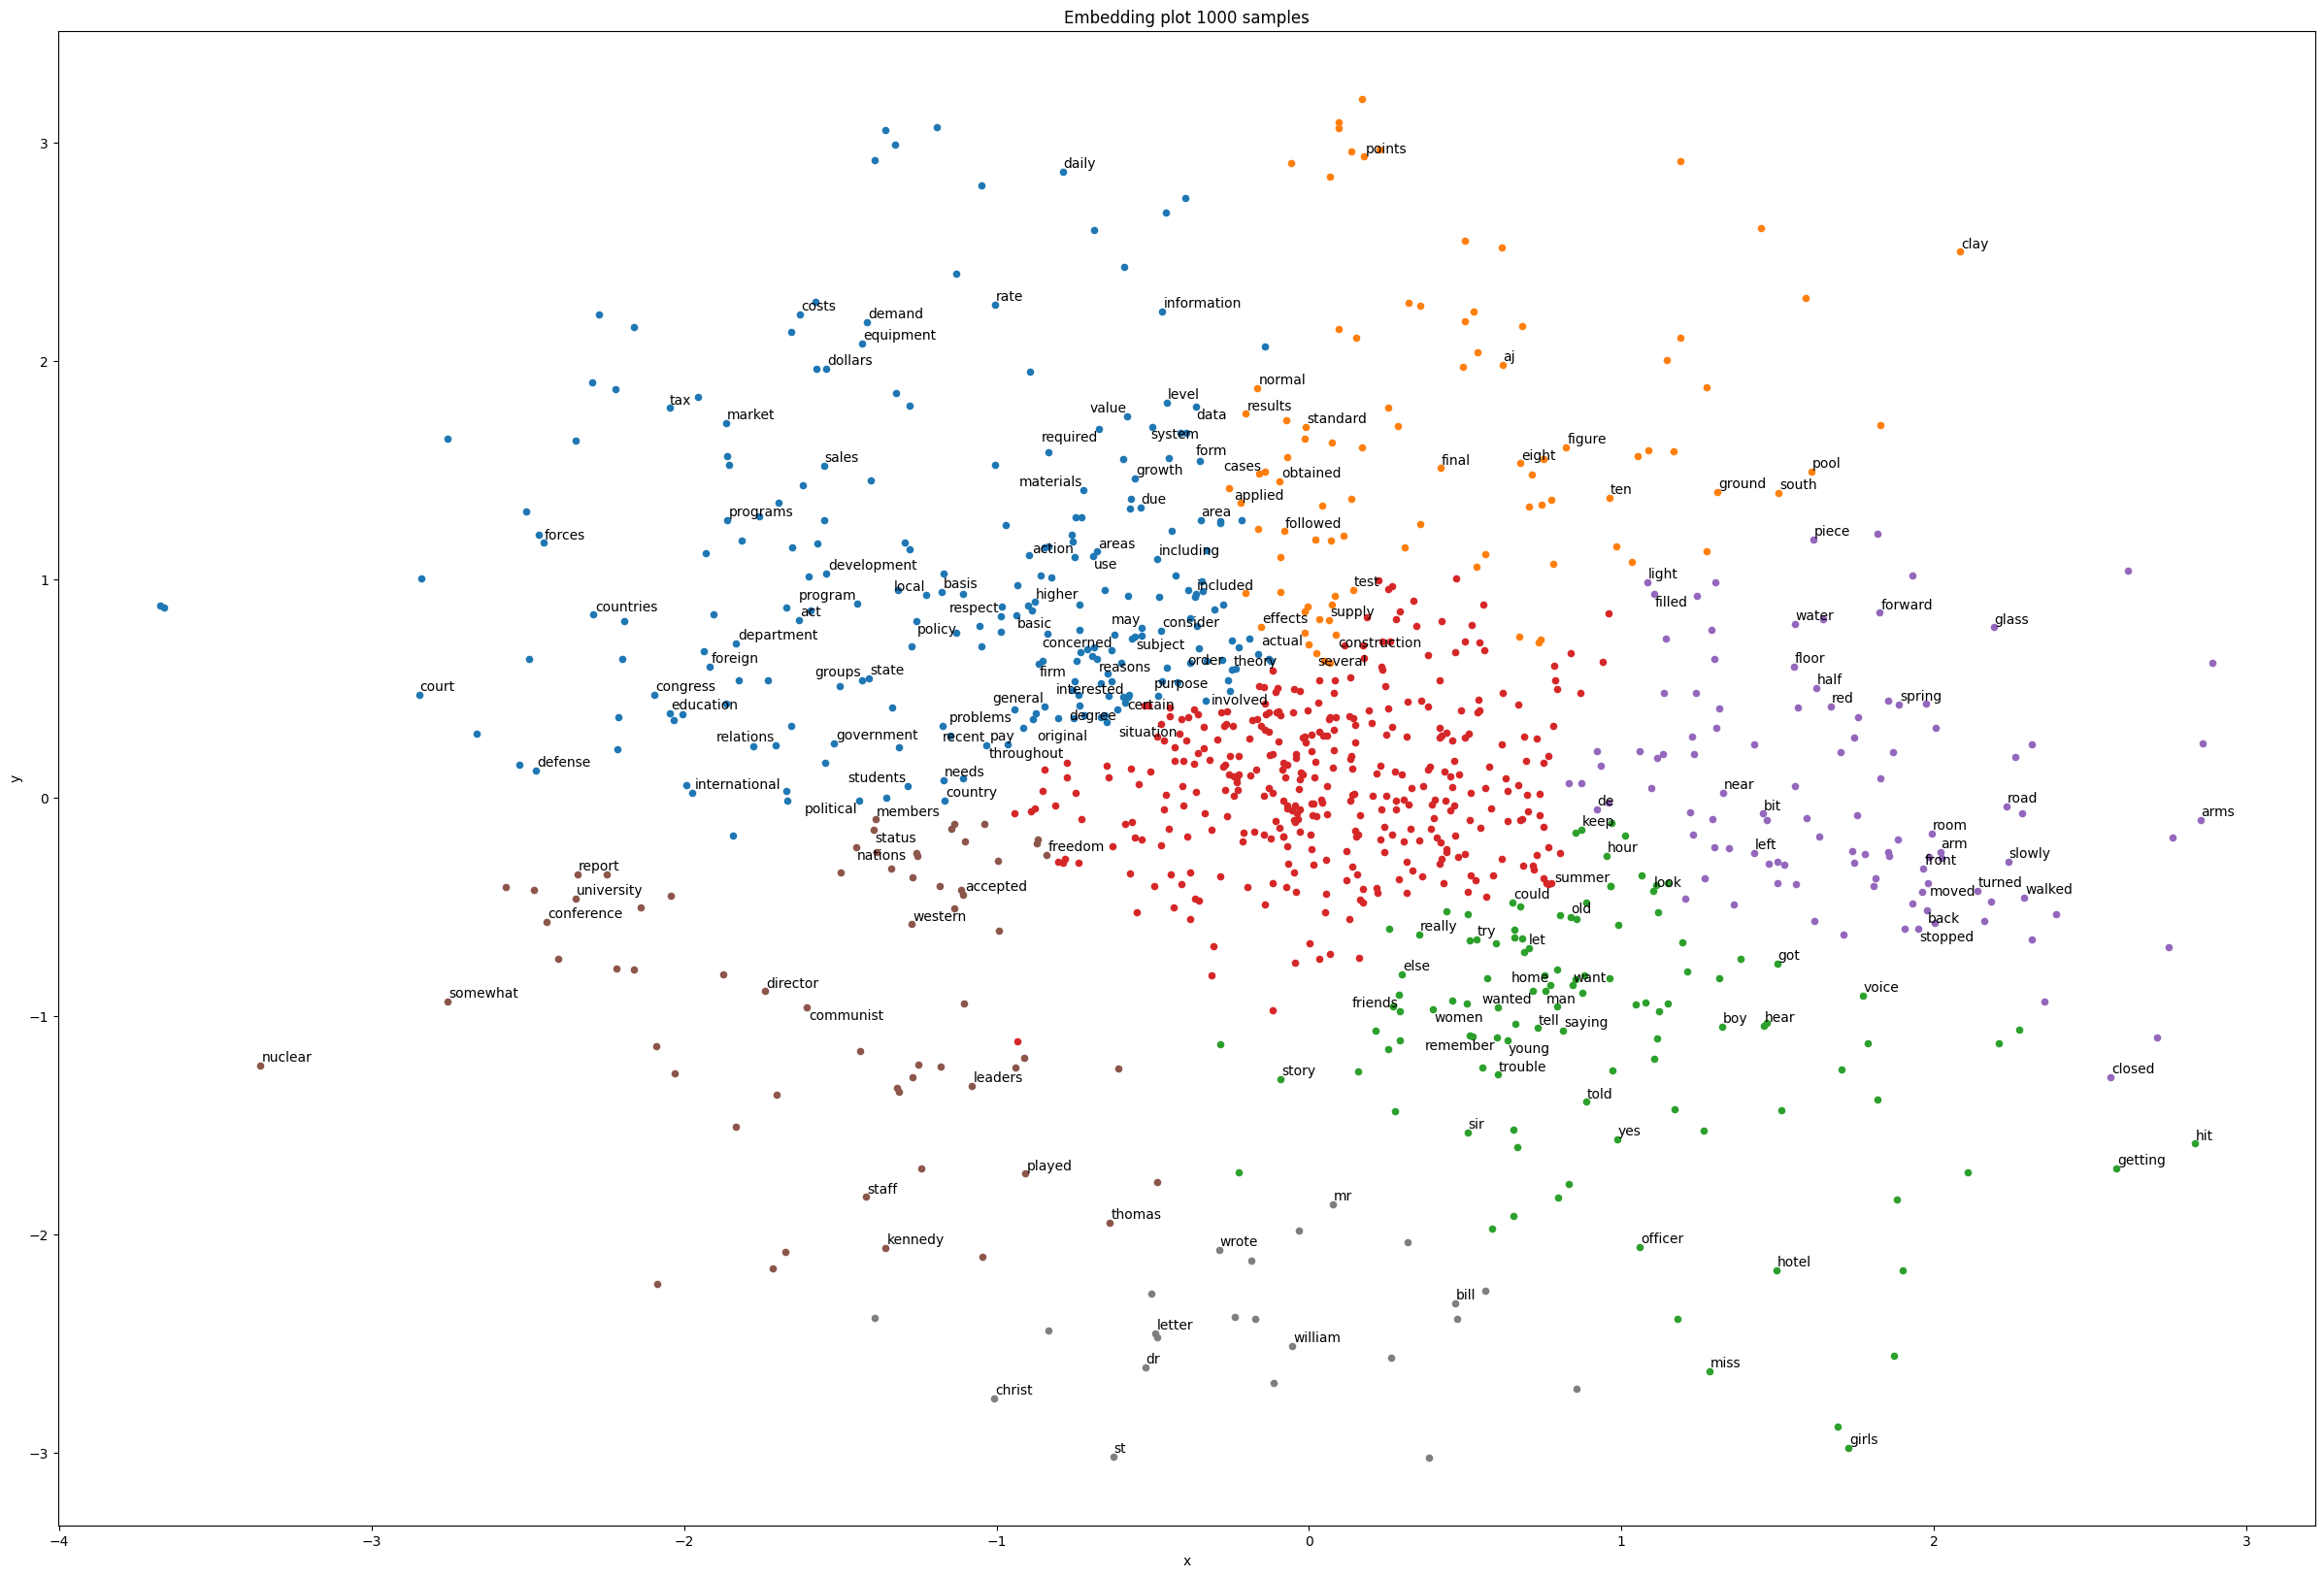

In [ ]:
!pip install adjustText
from sklearn.cluster import AgglomerativeClustering
from adjustText import adjust_text

np.random.seed(42)

plt.style.use('default')  # use default values to plot the embeddings

def plot_words(new_values,labels,to_plot,title,prob = 0.0,limit = 100,dim1=15,dim2=10):
    visualization_dataset = np.array(new_values[:to_plot])
    plt.rcParams["figure.figsize"] = (dim1,dim2)

    
    to_adjust= []
    for i in np.unique(labels):
        plt.scatter(visualization_dataset[np.array(labels)[:to_plot] == i,0],visualization_dataset[np.array(labels)[:to_plot] == i,1] ,label = i,s=20)  # plot the embedding points
        tmp_labels = np.array(labels == i)
        indices = []
        
        for index in range(to_plot):
            if tmp_labels[index]:
                indices.append(index)
        for j in range(len((visualization_dataset[np.array(labels)[:to_plot] == i,0]))):
            if(len(indices) < limit) :  # don't plot texts for bigger clusters
                if (np.random.rand() > prob): # print only a portion of the words to improve readibility
                    to_adjust.append(plt.text((visualization_dataset[np.array(labels)[:to_plot] == i,0])[j],(visualization_dataset[np.array(labels)[:to_plot] == i,1])[j], index_to_word[indices[j]]))  # plot the word on the correspnding embedding point
       
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    adjust_text(to_adjust)
    plt.show()

ag = AgglomerativeClustering(n_clusters=8).fit(new_values)  # use the fit function of the Clustering method using all the samples
labels = ag.labels_

plot_words(new_values,labels,100,'Embedding plot 100 samples',)

plot_words(new_values,labels,500,'Embedding plot 500 samples',0.40,150,dim1 =20,dim2=15)

plot_words(new_values,labels,1000,'Embedding plot 1000 samples',0.7,250,dim1=30,dim2=20)

### Analysis

As a first approach for the visualization part we just tried to visualize the embedding values with their corresponding word, but this result in a very messy and unclear plot, and it was not easy to identify thematic clusters.
In order to solve this problem we used a clustering methods (Agglomerative Clustering) with number of clusters equal to 8.
Furthermore we also decided to not print all the corresponding words to improve the readability of the plot, we used probabilities to decide which words to print (we didn't print the words in the center cluster as we believe that is not significant).

Starting from the first plot we can identify a cluster (the violet one) that contains words that refers to movement and also spatial adjectives such as away,around,came,back, while to the left we can see a cluster (the blue one) with words related to the education and politics as school, government, state, public.

Then by analysing the second plot we can see a cluster (the brown one) to the left, where we have words linked to the war such as society, war, history, peace, religious, president. Furthermore we can also see a cluster (the orange one) to the left that contains words that refer to coordinates such as north, south, center, space and miles. Moreover the cluster that we identified in the previous plot with spatial adjectives and words that refers to movement has many new words such as moved, went, brought, road.
 
Finally in the third and last plot we can identify a cluster (the grey one) in the bottom of the plot where we can observe a lot of first names such as William, Thomas, Kennedy and also some "honorific" words such as Mr, Dr, Mrs. 


To conclude, also with the plots analysis we can again state that the skip gram has found good embeddings in general, since we identified a lot of thematic clusters.